In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize' : (20,8)}, style='whitegrid')

n=3 # количество событий
deg=4 # max степеyь полинома

# ситываем все
df = pd.read_excel('files/smspecs_yearly.xlsx', sheet_name=None,  index_col=0)
# for k in df:
#     df[k]=df[k].loc[df[k].index.year<2025]


base_train_df=pd.DataFrame()
for key in [k for k in df if k.endswith('-xxxx'*3)]:
    df[key]['type']=int(key[:n], 2)
    base_train_df=pd.concat([base_train_df, df[key]])
    
base_df=base_train_df.loc[base_train_df.type==0]

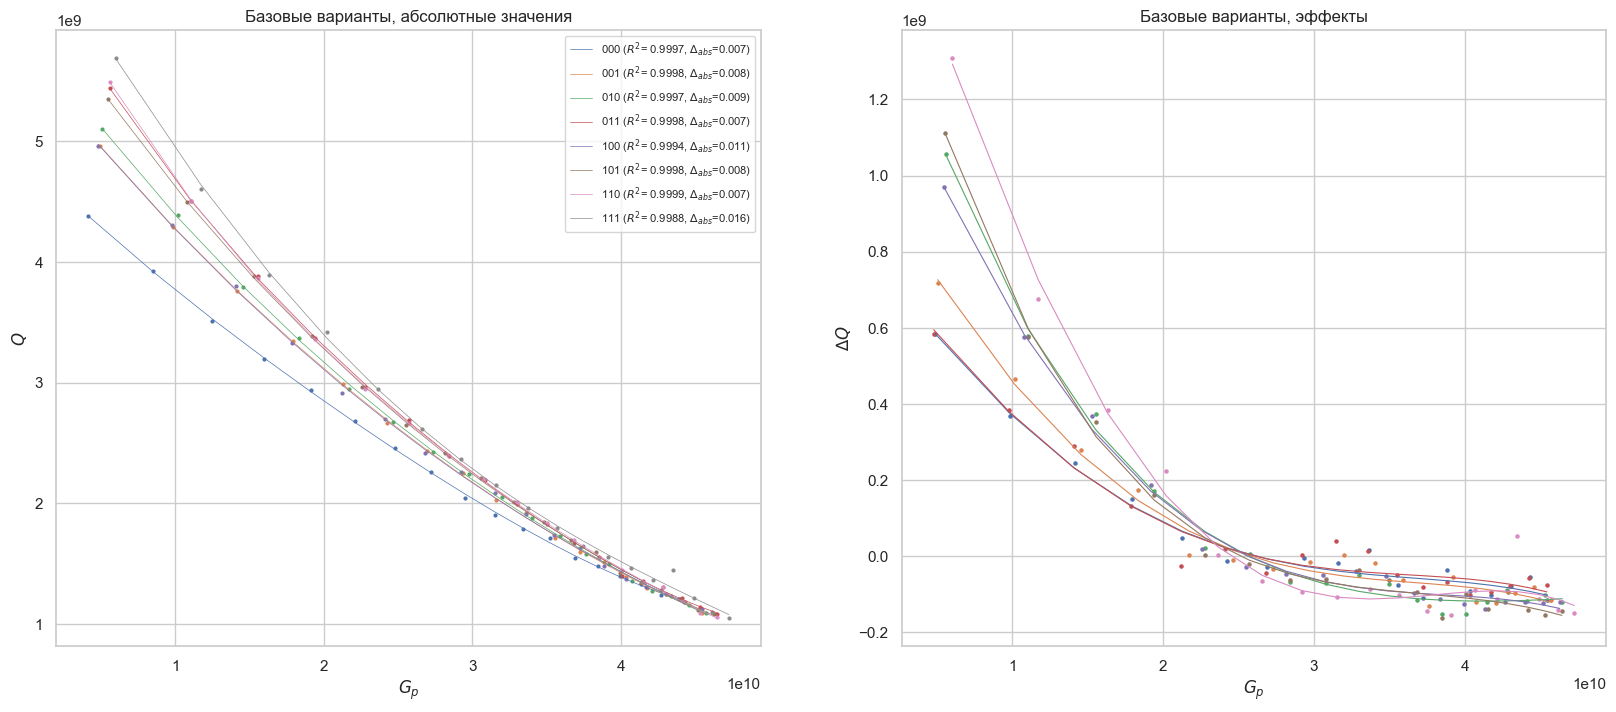

In [2]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# базовые варианты, тренды от накопленной и приросты
fig, ax = plt.subplots(ncols=2)
base_coefs=np.zeros((2**n, deg+1))
for i in range(2**n):
    d=base_train_df.loc[base_train_df.type==i]
    fQ=np.poly1d(np.polyfit(d.total, d.yearly, deg))
    fdQ=np.poly1d(np.polyfit(d.total, d.yearly-base_df.yearly, deg))
    
    r2=r2_score(d.yearly, fQ(d.total))
    mape=mean_absolute_percentage_error(d.yearly, fQ(d.total))
    label='$R^{2}$= %.4f, $∆_{abs}$=%.3f' % (r2, mape)
    
    ax[0].scatter(d.total, d.yearly, s=4)
    ax[0].plot(d.total, fQ(d.total), linewidth=0.5, label=f'{bin(i)[2:].zfill(n)} ({label})')
    if i>0:
        ax[1].scatter(d.total, d.yearly-base_df.yearly, s=5)
        ax[1].plot(d.total, fdQ(d.total), linewidth=0.8)

ax[0].set_title('Базовые варианты, абсолютные значения')
ax[1].set_title('Базовые варианты, эффекты')
ax[1].set_ylabel("$∆Q$")
ax[0].set_ylabel("$Q$")
ax[0].set_xlabel("$G_{p}$")
ax[1].set_xlabel("$G_{p}$")
ax[0].legend(fontsize=8)

Text(0.5, 0, '$t$')

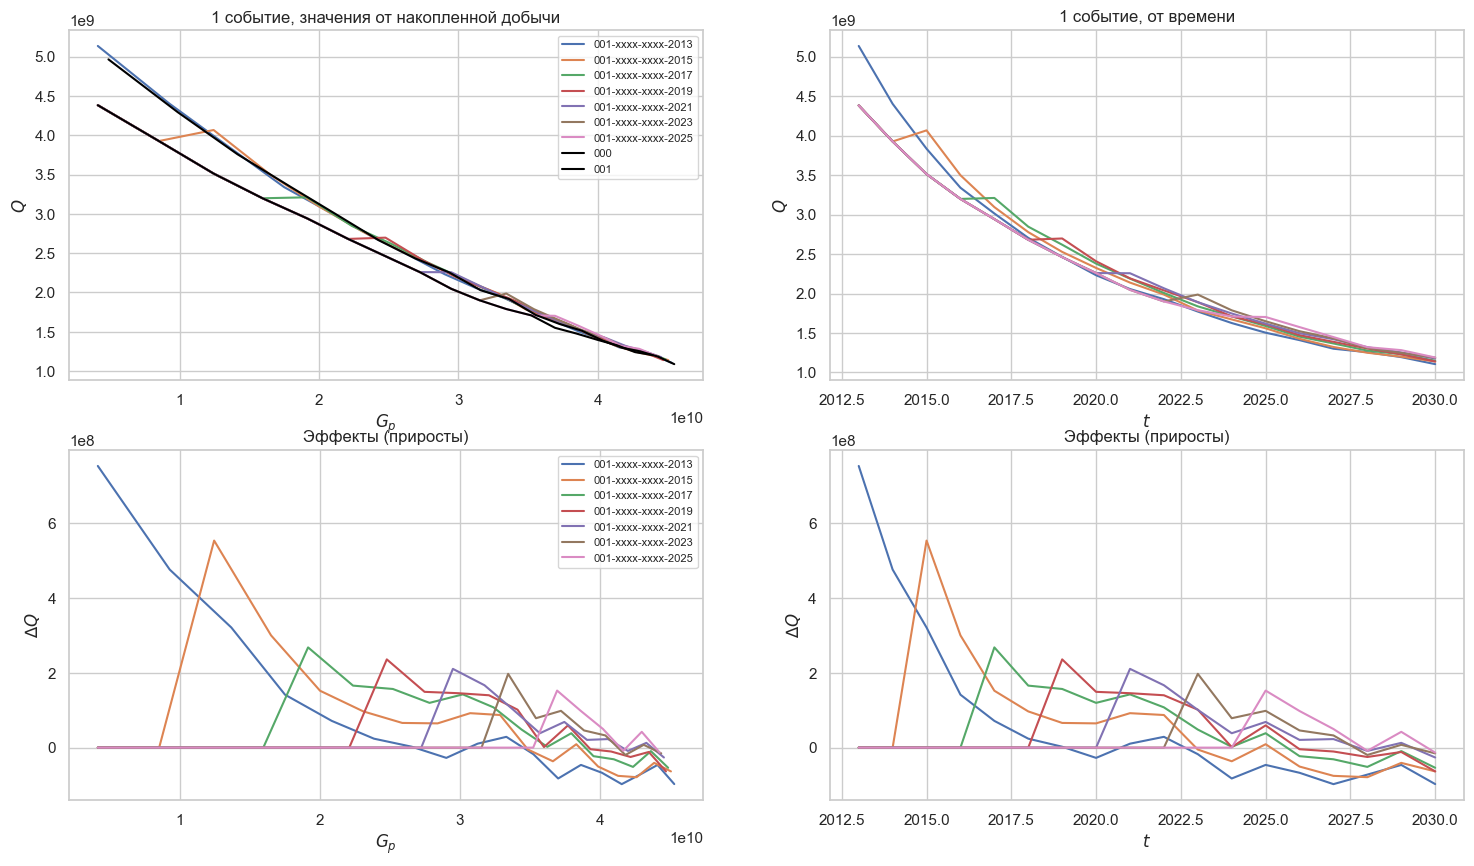

In [3]:
# 1 событие, рандомные годы, ограничиывющие прямые - бызоыве варианты
# + приросты

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,10))

keys=[k for k in df if int(k[:3], 2)==1 and k[3:]!='-xxxx'*3]
for k in keys:
    ax[0][0].plot(df[k].total, df[k].yearly, label=k)
    ax[1][0].plot(df[k].total, df[k].yearly-base_df.yearly, label=k)
    
    ax[0][1].plot(df[k].index.year.to_list(), df[k].yearly, label=k)
    ax[1][1].plot(df[k].index.year.to_list(), df[k].yearly-base_df.yearly, label=k)

ax[0][0].plot(df['000-xxxx-xxxx-xxxx'].total, df['000-xxxx-xxxx-xxxx'].yearly, color='black', label='000')
ax[0][0].plot(df['001-xxxx-xxxx-xxxx'].total, df['001-xxxx-xxxx-xxxx'].yearly, color='black', label='001')

ax[0][0].legend(fontsize=8)
ax[1][0].legend(fontsize=8)
ax[0][0].set_title('1 событие, значения от накопленной добычи')
ax[0][1].set_title('1 событие, от времени')
ax[1][0].set_title('Эффекты (приросты)')
ax[1][1].set_title('Эффекты (приросты)')
ax[1][0].set_ylabel("$∆Q$")
ax[0][0].set_ylabel("$Q$")

ax[1][1].set_ylabel("$∆Q$")
ax[0][1].set_ylabel("$Q$")

ax[0][0].set_xlabel("$G_{p}$")
ax[1][0].set_xlabel("$G_{p}$")

ax[0][1].set_xlabel("$t$")
ax[1][1].set_xlabel("$t$")

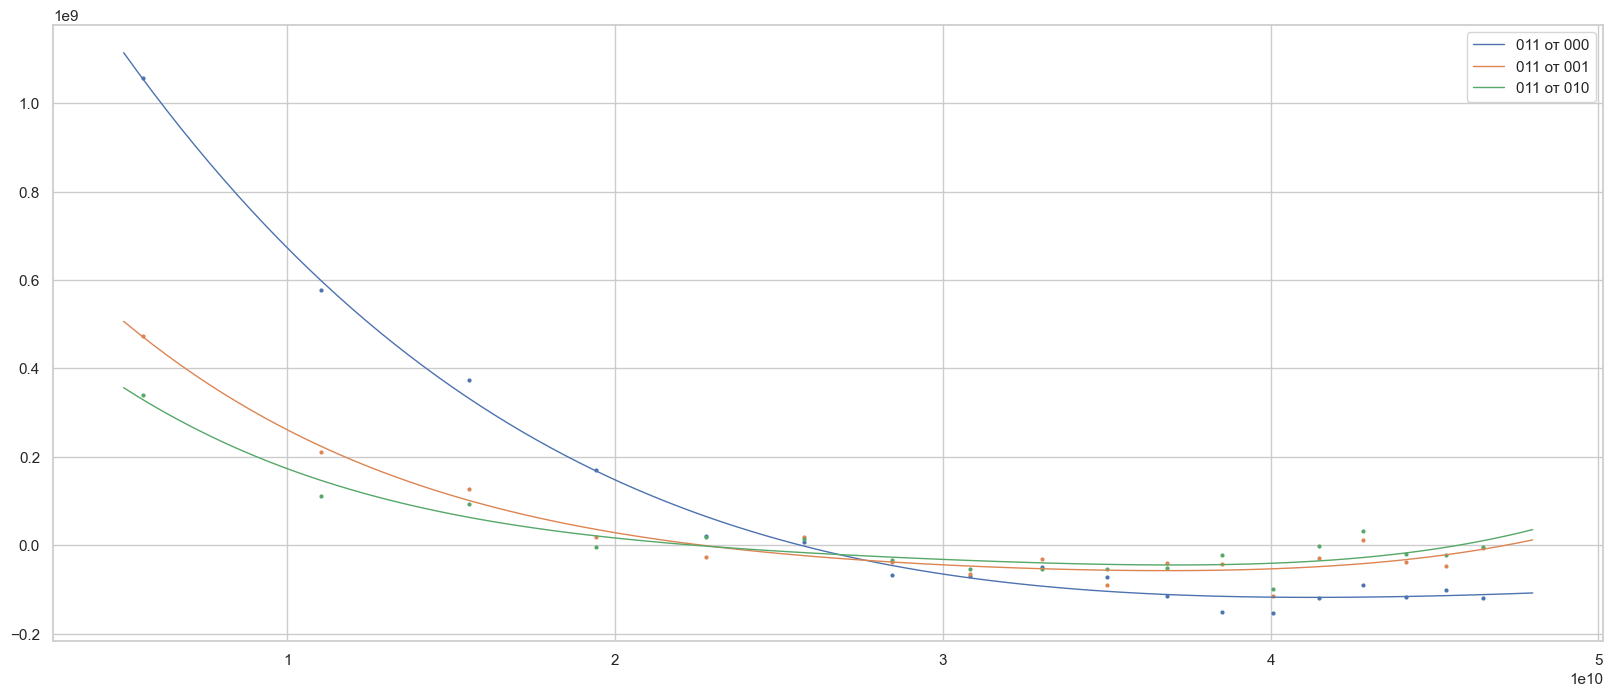

In [4]:
coef=np.empty((deg+1)*(2**n)**2, 'float64').reshape(2**n, 2**n, deg+1)
for i in range(2**n):
    # vi=format(i, '0{}b'.format(n))+'-xxxx'*n
    bi=bin(i)[2:].zfill(n)
    vi=bi+'-xxxx'*n
    for j in range(2**n):
        bj=bin(j)[2:].zfill(n)
        vj=bj+'-xxxx'*n
        # строим тренд
        if (i&j>0 and bj.count('1')>bi.count('1')) or i==0:
            fp = np.polyfit(df[vj].total, df[vj].yearly-df[vi].yearly, deg)
            coef[i][j]=fp
        else:
            coef[i][j]=[np.nan]*(deg+1)
        
v=3 # менять значения, для просмотра других зависимостей
vstr=format(v, '0{}b'.format(n))+'-xxxx'*n
x=np.linspace(0.5*(10**10),4.8*(10**10), 100)            
for i in range(len(coef)):
    if not np.isnan(coef[i][v]).any():
        f = np.poly1d(coef[i][v])
        vi=format(i, '0{}b'.format(n))+'-xxxx'*n
        plt.plot(x, f(x), linewidth=1, label=f'{vstr[:3]} от {vi[:3]}')
        plt.scatter(df[vstr].total, df[vstr].yearly-df[vi].yearly, s=4)
plt.legend()

ValueError: could not broadcast input array from shape (3,) into shape (5,)

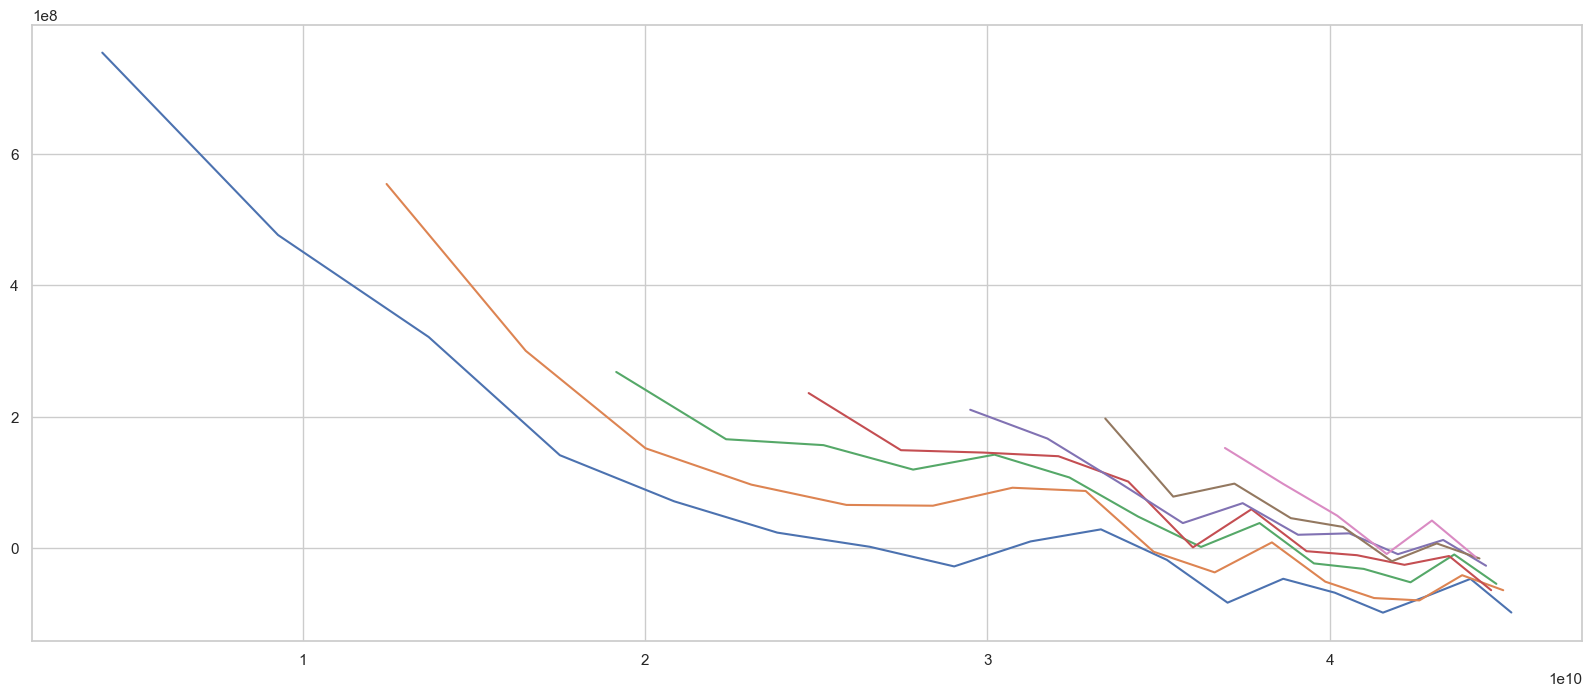

In [5]:
# тренды по приростам
train_set_keys=[[k for k in df if int(k[:3], 2)==v and k[3:]!='-xxxx'*3] for v in range(2**n)]
growth_coefs=np.zeros((2**n, deg+1))
base_df=base_train_df.loc[base_train_df.type==0]
deg=2
for i, keys in enumerate(train_set_keys[1:]):
    x, y = [], []
    for key in keys:
        g=df[key]
        g['growth_by_year']=g.yearly-base_df.yearly
        g=g.loc[g.growth_by_year.cumsum()>0]
        plt.plot(g.total, g.growth_by_year, label=key)

        if len(g)>0:
            x.append(g.iloc[0].total)
            y.append(g.iloc[0].growth_by_year)
        
    growth_coefs[i] = np.polyfit(x, y, deg)
    plt.scatter(x, y, color='black')
    xx=np.linspace(min(x), max(x), 100)
    plt.plot(xx, np.poly1d(growth_coefs[i])(xx), color='black')
    plt.xlabel('$G_{p}$')
    plt.ylabel('$∆Q$')
    plt.show()